In [3]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
import lightgbm as lgbm
import optuna
from optuna.visualization import plot_param_importances

# 1. Load data

In [4]:
df_rose = pd.read_csv(os.path.join('data', '.local', 'processed_data', 'ROSE_data.csv'))
df_smote = pd.read_csv(os.path.join('data', '.local', 'processed_data', 'SMOTE_data.csv'))
df_test = pd.read_csv(os.path.join('data', '.local', 'processed_data', 'TEST_data.csv'))
df_train = pd.read_csv(os.path.join('data', '.local', 'processed_data', 'TRAIN_data.csv'))

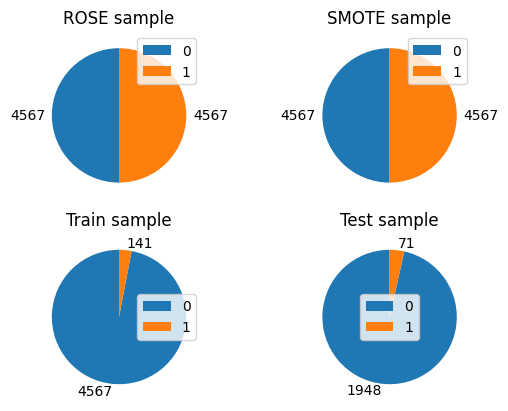

In [6]:
fig, axs = plt.subplots(2, 2)

X_rose = df_rose[df_rose.columns[:-1]].to_numpy()
Y_rose = df_rose['bankrupt'].to_numpy()
vc1 = pd.Series(Y_rose).value_counts()
axs[0, 0].pie(vc1.values, labels=vc1.values, startangle=90)
axs[0, 0].set_title('ROSE sample')
axs[0, 0].legend(vc1.index)

X_smote = df_smote[df_smote.columns[:-1]].to_numpy()
Y_smote = df_smote['bankrupt'].to_numpy()
vc2 = pd.Series(Y_smote).value_counts()
axs[0, 1].pie(vc2.values, labels=vc2.values, startangle=90)
axs[0, 1].set_title('SMOTE sample')
axs[0, 1].legend(vc2.index)

X_train = df_train[df_train.columns[:-1]].to_numpy()
Y_train = df_train['bankrupt'].to_numpy()
vc3 = pd.Series(Y_train).value_counts()
axs[1, 0].pie(vc3.values, labels=vc3.values, startangle=90)
axs[1, 0].set_title('Train sample')
axs[1, 0].legend(vc3.index)

X_test = df_test[df_test.columns[:-1]].to_numpy()
Y_test = df_test['bankrupt'].to_numpy()
vc4 = pd.Series(Y_test).value_counts()
axs[1, 1].pie(vc4.values, labels=vc4.values, startangle=90)
axs[1, 1].set_title('Test sample')
axs[1, 1].legend(vc4.index)

plt.show()

# Optuna optizmization

In [7]:
def objective(trial):
    dtrain = lgbm.Dataset(X_rose, label=Y_rose)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 2000),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 256),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "colsample_bytree": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
    }
    

    gbm = lgbm.train(param, dtrain)
    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    f1 = f1_score(Y_test, pred_labels)
    return f1

In [ ]:
plotly_config = {"staticPlot": True}
fig = plot_param_importances(study)
fig.show(config=plotly_config)